# Searching Unstructured and Structured Data #
## Assignment 1: Retrieval models [100 points] ##
**TA**: Nikos Voskarides (n.voskarides@uva.nl)

In this assignment you will get familiar with basic information retrieval concepts. You will implement and evaluate different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Monday, 22/1, at 23:59**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](https://piazza.com/class/ixoz63p156g1ts).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [1]:
import time
import numpy as np

In [2]:
import logging
import sys
import os

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example
Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example


Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.

    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

In [3]:
# ./trec_eval

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [4]:
import pyndri

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [5]:
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

In [6]:
example_document = index.document(index.document_base())
print(example_document)

('AP890425-0001', (1360, 192, 363, 0, 880, 0, 200, 0, 894, 412, 92160, 3, 192, 0, 363, 34, 1441, 0, 174134, 0, 200, 0, 894, 412, 2652, 0, 810, 107, 49, 4903, 420, 0, 1, 48, 35, 489, 0, 35, 687, 192, 243, 0, 249311, 1877, 0, 1651, 1174, 0, 2701, 117, 412, 0, 810, 391, 245233, 1225, 5838, 16, 0, 233156, 3496, 0, 393, 17, 0, 2435, 4819, 930, 0, 0, 200, 0, 894, 0, 22, 398, 145, 0, 3, 271, 115, 0, 1176, 2777, 292, 0, 725, 192, 0, 0, 50046, 0, 1901, 1130, 0, 192, 0, 408, 0, 243779, 0, 0, 553, 192, 0, 363, 0, 3747, 0, 0, 0, 0, 1176, 0, 1239, 0, 0, 1115, 17, 0, 0, 585, 192, 1963, 0, 0, 412, 54356, 0, 773, 0, 0, 0, 192, 0, 0, 1130, 0, 363, 0, 545, 192, 0, 1174, 1901, 1130, 0, 4, 398, 145, 39, 0, 577, 0, 355, 0, 491, 0, 6025, 0, 0, 193156, 88, 34, 437, 0, 0, 1852, 0, 828, 0, 1588, 0, 0, 0, 2615, 0, 0, 107, 49, 420, 0, 0, 190, 7, 714, 2701, 0, 237, 192, 157, 0, 412, 34, 437, 0, 0, 200, 6025, 26, 0, 0, 0, 0, 363, 0, 22, 398, 145, 0, 200, 638, 126222, 6018, 0, 880, 0, 0, 161, 0, 0, 319, 894, 2701, 

Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens we take a look at the dictionary of the index:

In [7]:
token2id, id2token, _ = index.get_dictionary()
print(list(id2token.items())[:15])

[(1, 'new'), (2, 'percent'), (3, 'two'), (4, '1'), (5, 'people'), (6, 'million'), (7, '000'), (8, 'government'), (9, 'president'), (10, 'years'), (11, 'state'), (12, '2'), (13, 'states'), (14, 'three'), (15, 'time')]


Using this dictionary we can see the tokens for the (non-stop) words in our example document:

In [8]:
print([id2token[word_id] for word_id in example_document[1] if word_id > 0])

['52', 'students', 'arrested', 'takeover', 'university', 'massachusetts', 'building', 'fifty', 'two', 'students', 'arrested', 'tuesday', 'evening', 'occupying', 'university', 'massachusetts', 'building', 'overnight', 'protest', 'defense', 'department', 'funded', 'research', 'new', 'york', 'city', 'thousands', 'city', 'college', 'students', 'got', 'unscheduled', 'holiday', 'demonstrators', 'occupied', 'campus', 'administration', 'building', 'protest', 'possible', 'tuition', 'increases', 'prompting', 'officials', 'suspend', 'classes', '60', 'police', 'riot', 'gear', 'arrived', 'university', 'massachusetts', '5', 'p', 'm', 'two', 'hours', 'later', 'bus', 'drove', 'away', '29', 'students', 'camped', 'memorial', 'hall', 'students', 'charged', 'trespassing', '23', 'students', 'arrested', 'lying', 'bus', 'prevent', 'leaving', 'police', '300', 'students', 'stood', 'building', 'chanting', 'looking', 'students', 'hall', 'arrested', '35', 'students', 'occupied', 'memorial', 'hall', '1', 'p', 'm',

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

In [9]:
# tokenizing
query_tokens = index.tokenize("University of Massachusetts")
print("Query by tokens:", query_tokens)
# get the token ids
query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
print("Query by ids with stopwords:", query_id_tokens)
# token ids without stop words (where token_id = 0)
query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
print("Query by ids without stopwords:", query_id_tokens)

Query by tokens: ['university', '', 'massachusetts']
Query by ids with stopwords: [200, 0, 894]
Query by ids without stopwords: [200, 894]


Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

In [10]:
matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
print("Document %s has %d word matches with query: \"%s\"." % (example_document[0], matching_words, ' '.join(query_tokens)))
print("Document %s and query \"%s\" have a %.01f%% overlap." % (example_document[0], ' '.join(query_tokens),matching_words/float(len(example_document[1]))*100))

Document AP890425-0001 has 13 word matches with query: "university  massachusetts".
Document AP890425-0001 and query "university  massachusetts" have a 2.5% overlap.


While this is certainly not everything Pyndri can do, it should give you an idea of how to use it. Please take a look at the [examples](https://github.com/cvangysel/pyndri) as it will help you a lot with this assignment.

**CAUTION**: Avoid printing out the whole index in this Notebook as it will generate a lot of output and is likely to corrupt the Notebook.

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [11]:
import collections
import io
import logging
import sys

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

with open('./ap_88_89/topics_title', 'r') as f_topics:
    print(parse_topics([f_topics]))

OrderedDict([('51', 'Airbus Subsidies'), ('52', 'South African Sanctions'), ('53', 'Leveraged Buyouts'), ('54', 'Satellite Launch Contracts'), ('55', 'Insider Trading'), ('56', 'Prime (Lending) Rate Moves, Predictions'), ('57', 'MCI'), ('58', 'Rail Strikes'), ('59', 'Weather Related Fatalities'), ('60', 'Merit-Pay vs. Seniority'), ('61', 'Israeli Role in Iran-Contra Affair'), ('62', "Military Coups D'etat"), ('63', 'Machine Translation'), ('64', 'Hostage-Taking'), ('65', 'Information Retrieval Systems'), ('66', 'Natural Language Processing'), ('67', 'Politically Motivated Civil Disturbances'), ('68', 'Health Hazards from Fine-Diameter Fibers'), ('69', 'Attempts to Revive the SALT II Treaty'), ('70', 'Surrogate Motherhood'), ('71', 'Border Incursions'), ('72', 'Demographic Shifts in the U.S.'), ('73', 'Demographic Shifts across National Boundaries'), ('74', 'Conflicting Policy'), ('75', 'Automation'), ('76', 'U.S. Constitution - Original Intent'), ('77', 'Poaching'), ('78', 'Greenpeace'

### Task 1: Implement and compare lexical IR methods [40 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html). **[5 points]**
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[10 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[10 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand how the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [12]:
for int_doc_id in range(index.document_base(), index.document_base()+1):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    print(document_bow)

Counter({192: 13, 420: 10, 200: 9, 363: 6, 412: 6, 2701: 5, 34: 4, 1130: 4, 114: 4, 687: 4, 894: 4, 35: 3, 49: 3, 107: 3, 145: 3, 398: 3, 714: 3, 25480: 3, 6025: 3, 1901: 3, 245233: 3, 1: 2, 3: 2, 4: 2, 17: 2, 79893: 2, 22: 2, 39: 2, 553: 2, 48: 2, 243779: 2, 117: 2, 70268: 2, 1174: 2, 1176: 2, 1200: 2, 4903: 2, 810: 2, 55: 2, 880: 2, 392: 2, 497: 2, 3496: 2, 437: 2, 92160: 1, 2: 1, 6: 1, 7: 1, 10: 1, 11: 1, 1549: 1, 15: 1, 16: 1, 583: 1, 25: 1, 26: 1, 545: 1, 36: 1, 1588: 1, 53: 1, 174134: 1, 2615: 1, 23610: 1, 61: 1, 574: 1, 63: 1, 577: 1, 3141: 1, 71: 1, 72: 1, 585: 1, 159306: 1, 79: 1, 54356: 1, 2133: 1, 88: 1, 3162: 1, 1115: 1, 2652: 1, 2654: 1, 97: 1, 104: 1, 2160: 1, 1128: 1, 115: 1, 121: 1, 125: 1, 638: 1, 129: 1, 2178: 1, 875: 1, 193156: 1, 645: 1, 651: 1, 151: 1, 196764: 1, 157: 1, 161: 1, 3747: 1, 171: 1, 178: 1, 1651: 1, 188: 1, 190: 1, 195: 1, 233156: 1, 198: 1, 192545: 1, 1225: 1, 1738: 1, 715: 1, 5838: 1, 207: 1, 4819: 1, 725: 1, 214: 1, 1239: 1, 729: 1, 1627: 1, 2789: 1

In [13]:
with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')

num_documents = index.maximum_document() - index.document_base()
print("Number of documents: ", num_documents)

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}
 
print("Length of tokenized queries: ", len(tokenized_queries))

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print("Length of query term ids: ", len(query_term_ids))

# print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

total_terms = 0

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        # frequency of a term in all documents
        collection_frequencies[query_term_id] += document_term_frequency
        # frequency of a term in a particular document
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

# avg_doc_length
avg_doc_length = total_terms / num_documents
print("Average document length: ", avg_doc_length)

doc_no = index.maximum_document()- index.document_base()
print("Number of documents: ", avg_doc_length)

Number of documents:  164597
Length of tokenized queries:  150
Length of query term ids:  456
Average document length:  256.4381975370147
Number of documents:  256.4381975370147


In [14]:
type(collection_frequencies)

collections.defaultdict

In [15]:
collection_frequencies[30]

0

In [16]:
# collection_frequencies[query_id], inverted_index[query_term_id][doc_id]

In [17]:
# tfidf(int_document_id, query_term_id, document_term_freq)
# tf_idfs[query_id][doc_id] = tfidf() for doc_id in range(index.document_base(), index.maximum_document())

In [18]:
collection_frequencies[3076]

2596

In [19]:
type(collection_frequencies)
# collection_frequencies

collections.defaultdict

In [20]:
## inverted_index
# inverted_index[query_term_id][int_doc_id] = document_term_frequency
inverted_index[1][10]

3

In [21]:
index.document(189)[0]

'AP890425-0189'

In [22]:
inverted_index[1][1]

2

In [23]:
tokenized_queries['100']

[63065, 3063, 68, 1178]

In [24]:
def run_retrieval(model_name, score_fn):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    run_out_path = '{}.run'.format(model_name)

    if os.path.exists(run_out_path):
        return

    retrieval_start_time = time.time()

    print('Retrieving using', model_name)

    data = {}

    # TODO: fill the data dictionary. 
    # The dictionary data should have the form: query_id --> (document_score, external_doc_id)
    
    # for every query for every term
    # get all queries, calculate the sum of tf-idf for all of the terms in the query
    
    
    
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)

In [25]:
type(inverted_index)

collections.defaultdict

In [26]:
import numpy as np

In [27]:
matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
# word matches
example_document[0], matching_words, ' '.join(query_tokens)

('AP890425-0001', 13, 'university  massachusetts')

In [28]:
doc_temp = index.document(10)
query_term_id = 400

In [29]:
def tfidf(int_document_id, query_term_id, document_term_freq):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """
    
    # TODO implement the function
    
    idf = np.log(num_documents / collection_frequencies[query_term_id])
    tf = np.log(1 + document_term_freq)
    
    score = tf*idf
    return score

# combining the two functions above: 
# run_retrieval('tfidf', tfidf)

# TODO implement the rest of the retrieval functions 

# Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). [5 points]

# TODO implement tools to help you with the analysis of the results.


def dirichlet_prior(int_document_id, query_term_id, document_term_freq, mu):
    return (np.log10((document_term_freq + mu*collection_frequencies[query_term_id]) / (document_lengths[int_document_id] + mu)))


def jelinek_mercer(int_document_id, query_term_id, document_term_freq, l_val):
    return (np.log10(l_val*document_term_freq)/document_lengths[int_document_id]) + ((1-l_val)*collection_frequencies[query_term_id]/ total_terms)

def bm25(int_document_id, query_term_id, document_term_freq):
    k1 = 1.2
    b = 0.75
    ld = document_lengths[int_document_id]
    lavg = avg_doc_length
    tf = document_term_freq
    df = collection_frequencies[query_term_id]
    score = np.log(((k1+1)*tf)/(k1*((1-b)+b*(ld/lavg))+tf))
    return score

def abs_discounting(int_document_id, query_term_id, document_term_freq, d):
    #d = 0.1, 0.5, 0.9
    df =  collection_frequencies[query_term_id]
    pwc = df/doc_no  # ( tf(w;C)/|C| )
    doc_length = document_lengths[int_document_id]
    doc_length_unique = unique_terms_per_document[int_document_id]
    
    score = np.log((np.maximum(df-d, 0)/doc_length)+(d*doc_length_unique/doc_length)*pwc)
    return score

In [120]:
# calculating all scores together

scores_tuple = collections.defaultdict(dict)

for int_doc_id in range(index.document_base(), index.document_base()+10): # index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_id in tokenized_queries: 
        
        query_scores = list(np.zeros(11))

        # for query_term_id in query_term_ids:
        for query_term_id in tokenized_queries[query_id]:
    
            assert query_term_id is not None

            document_term_frequency = document_bow.get(query_term_id, 0)

            if document_term_frequency == 0:
                continue

            # frequency of a term in all documents
            collection_frequencies[query_term_id] += document_term_frequency
            # frequency of a term in a particular document
            inverted_index[query_term_id][int_doc_id] = document_term_frequency

            tf = document_term_frequency
            
            # scoring functions
            
            query_scores[0] += tfidf(int_doc_id, query_term_id, tf)
            
            query_scores[1] += bm25(int_doc_id, query_term_id, tf)
            
            query_scores[2] += dirichlet_prior(int_doc_id, query_term_id, tf, mu=500)
            query_scores[3] += dirichlet_prior(int_doc_id, query_term_id, tf, mu=1000)
            query_scores[4] += dirichlet_prior(int_doc_id, query_term_id, tf, mu=1500)
            
            
            query_scores[5] += jelinek_mercer(int_doc_id, query_term_id, tf, l_val = 0.1)
            query_scores[6] += jelinek_mercer(int_doc_id, query_term_id, tf, l_val = 0.5)
            query_scores[7] += jelinek_mercer(int_doc_id, query_term_id, tf, l_val = 0.9)
            
            
            query_scores[8] += abs_discounting(int_doc_id, query_term_id, tf, d = 0.1)
            query_scores[9] += abs_discounting(int_doc_id, query_term_id, tf, d = 0.5)
            query_scores[10] += abs_discounting(int_doc_id, query_term_id, tf, d = 0.9)
        
        scores_tuple[(query_id, int_doc_id)] = query_scores

In [121]:
scores_tuple[('100', 10)]

[0.94984772279010643,
 -0.21911479140016119,
 4.3612191875504269,
 4.4720714524930356,
 4.5163484534940066,
 -0.0015476292918545154,
 -0.00023900000251425135,
 -1.2559735692798741e-05,
 4.6249295408563071,
 4.6256170803787535,
 4.6263041475153699]

In [125]:
scores_dict = {}

scores_dict['tfidf'] = [v[0] for k, v in scores_tuple.items()]

scores_dict['bm25']  = [v[1] for k, v in scores_tuple.items()]

scores_dict['dirichlet500'] = [v[2] for k, v in scores_tuple.items()]
scores_dict['dirichlet1000'] = [v[3] for k, v in scores_tuple.items()]
scores_dict['dirichlet1500'] = [v[4] for k, v in scores_tuple.items()]

scores_dict['jelinek01'] = [v[5] for k, v in scores_tuple.items()]
scores_dict['jelinek05'] = [v[6] for k, v in scores_tuple.items()]
scores_dict['jelinek09'] = [v[7] for k, v in scores_tuple.items()]

scores_dict['abs_discounting01'] = [v[8] for k, v in scores_tuple.items()]
scores_dict['abs_discounting05'] = [v[9] for k, v in scores_tuple.items()]
scores_dict['abs_discounting09'] = [v[10] for k, v in scores_tuple.items()]


scores_dict['tfidf'][5], scores_dict['bm25'][5]

(1.8172690895482615, -0.28121486721549505)

In [126]:
len(scores_dict)

11

In [123]:
# https://stackoverflow.com/questions/29561360/how-to-calculate-p-value-for-two-lists-of-floats
from scipy import stats
import pandas as pd
from itertools import combinations
from statsmodels.sandbox.stats.multicomp import multipletests
p_values = {}


for list1, list2 in combinations(scores_dict.keys(), 2):
    t, p = stats.ttest_rel(scores_dict[list1], scores_dict[list2])
    
    comp_name = str(list1) + "_" + str(list2)
    p_values[comp_name] = [p]
    # print(list1, list2, p)
    

p_values = pd.DataFrame(data=p_values).T.reset_index()
p_values.columns = ['models_compared', 'p-value']


p_values_corr = multipletests(list(p_values['p-value']), alpha=0.05, method='bonferroni')
p_values['p_values_corr'] = p_values_corr[1]
p_values['h0_rejected'] = p_values_corr[0]
p_values = p_values.sort_values(by='p_values_corr', ascending=True)
p_values.reset_index(inplace=True, drop=True)
p_values

,models_compared,p-value,p_values_corr,h0_rejected
0,bm25_dirichlet500,1.370866e-51,3.838423e-50,True
1,bm25_dirichlet1000,1.387706e-51,3.885576e-50,True
2,bm25_dirichlet1500,1.399322e-51,3.918101e-50,True
3,jelinek05_dirichlet1500,2.163961e-51,6.059092e-50,True
4,jelinek09_dirichlet1500,2.168860e-51,6.072807e-50,True
5,jelinek05_dirichlet1000,2.181614e-51,6.108519e-50,True
6,jelinek09_dirichlet1000,2.186499e-51,6.122197e-50,True
7,jelinek05_dirichlet500,2.243256e-51,6.281117e-50,True
8,jelinek09_dirichlet500,2.248153e-51,6.294828e-50,True
9,bm25_jelinek01,8.697439e-50,2.435283e-48,True


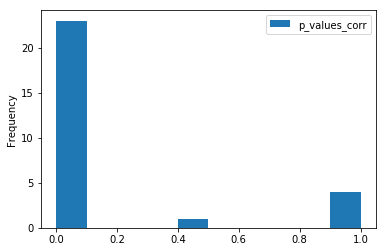

In [34]:
%matplotlib inline
p_values[['models_compared', 'p_values_corr']].plot(kind='hist')

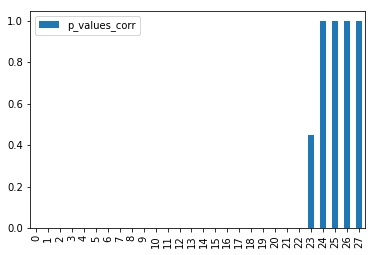

In [35]:
p_values[['models_compared', 'p_values_corr']].plot(kind='bar')

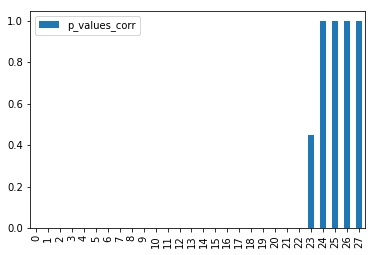

In [36]:
p_values[['models_compared', 'p_values_corr']].plot(kind='bar', )

In [37]:
p_values['models_compared'], p_values['p_values_corr']

(0               bm25_dirichlet500
 1              bm25_dirichlet1000
 2              bm25_dirichlet1500
 3         jelinek05_dirichlet1500
 4         jelinek09_dirichlet1500
 5         jelinek05_dirichlet1000
 6         jelinek09_dirichlet1000
 7          jelinek05_dirichlet500
 8          jelinek09_dirichlet500
 9                  bm25_jelinek01
 10            jelinek05_jelinek01
 11            jelinek09_jelinek01
 12     dirichlet500_dirichlet1000
 13     dirichlet500_dirichlet1500
 14    dirichlet1000_dirichlet1500
 15            tfidf_dirichlet1500
 16            dirichlet1000_tfidf
 17             dirichlet500_tfidf
 18                     bm25_tfidf
 19                jelinek05_tfidf
 20                jelinek09_tfidf
 21                jelinek01_tfidf
 22            jelinek05_jelinek09
 23         dirichlet500_jelinek01
 24        jelinek01_dirichlet1500
 25        jelinek01_dirichlet1000
 26                 jelinek09_bm25
 27                 jelinek05_bm25
 Name: models_compar

In [38]:
scores_tuple[('100',6)]

[0.94994719856245857,
 -0.19709062913337505,
 4.3693467939936124,
 4.4772771217335992,
 4.5201688797865884,
 -0.0016531698936222495,
 -0.00027077998358596275,
 -1.7391343861922535e-05,
 4.6671560501670539,
 4.667933406152379,
 4.668710158324723]

In [39]:
# basic t-test

from scipy import stats

rvs1 = stats.norm.rvs(loc=5, scale=10, size=500)
rvs2 = (stats.norm.rvs(loc=5, scale=10, size=500) + stats.norm.rvs(scale=0.2, size=500))

stats.ttest_rel(rvs1, rvs2)

Ttest_relResult(statistic=0.81962597118786118, pvalue=0.412820665942356)

In [40]:
tokenized_queries['103']

[2845, 917]

### Task 2: Latent Semantic Models (LSMs) [20 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

Perform analysis **[5 points]**

In [41]:
import gensim
import pyndri.compat
from gensim import corpora, models, similarities

In [42]:
class IndriCorpus(gensim.interfaces.CorpusABC):

    def __init__(self, index, dictionary, max_documents=None):
        assert isinstance(index, pyndri.Index)

        self.index = index
        self.dictionary = dictionary

        self.max_documents = max_documents

    def _maximum_document(self):
        if self.max_documents is None:
            return self.index.maximum_document()
        else:
            return min(
                self.max_documents + self.index.document_base(),
                self.index.maximum_document())

    def __iter__(self):
        for int_doc_id in range(self.index.document_base(),
                                self._maximum_document()):
            ext_doc_id, tokens = self.index.document(int_doc_id)

            # Compared to IndriSentences, the only difference is the
            # switching of tuple(self.dictionary[token_id] ...) by
            # sorted(collections.Counter(token_id ...).items()).
            yield sorted(collections.Counter(
                token_id
                for token_id in tokens
                if token_id > 0 and token_id in self.dictionary).items())

In [73]:
type(index)

pyndri.Index

In [78]:
index.document(1)

('AP890425-0001',
 (1360,
  192,
  363,
  0,
  880,
  0,
  200,
  0,
  894,
  412,
  92160,
  3,
  192,
  0,
  363,
  34,
  1441,
  0,
  174134,
  0,
  200,
  0,
  894,
  412,
  2652,
  0,
  810,
  107,
  49,
  4903,
  420,
  0,
  1,
  48,
  35,
  489,
  0,
  35,
  687,
  192,
  243,
  0,
  249311,
  1877,
  0,
  1651,
  1174,
  0,
  2701,
  117,
  412,
  0,
  810,
  391,
  245233,
  1225,
  5838,
  16,
  0,
  233156,
  3496,
  0,
  393,
  17,
  0,
  2435,
  4819,
  930,
  0,
  0,
  200,
  0,
  894,
  0,
  22,
  398,
  145,
  0,
  3,
  271,
  115,
  0,
  1176,
  2777,
  292,
  0,
  725,
  192,
  0,
  0,
  50046,
  0,
  1901,
  1130,
  0,
  192,
  0,
  408,
  0,
  243779,
  0,
  0,
  553,
  192,
  0,
  363,
  0,
  3747,
  0,
  0,
  0,
  0,
  1176,
  0,
  1239,
  0,
  0,
  1115,
  17,
  0,
  0,
  585,
  192,
  1963,
  0,
  0,
  412,
  54356,
  0,
  773,
  0,
  0,
  0,
  192,
  0,
  0,
  1130,
  0,
  363,
  0,
  545,
  192,
  0,
  1174,
  1901,
  1130,
  0,
  4,
  398,
  145,
  39,
  0,
 

In [76]:
type(index_models)

list

In [77]:
index_models[0]

('AP890425-0001',
 (1360,
  192,
  363,
  0,
  880,
  0,
  200,
  0,
  894,
  412,
  92160,
  3,
  192,
  0,
  363,
  34,
  1441,
  0,
  174134,
  0,
  200,
  0,
  894,
  412,
  2652,
  0,
  810,
  107,
  49,
  4903,
  420,
  0,
  1,
  48,
  35,
  489,
  0,
  35,
  687,
  192,
  243,
  0,
  249311,
  1877,
  0,
  1651,
  1174,
  0,
  2701,
  117,
  412,
  0,
  810,
  391,
  245233,
  1225,
  5838,
  16,
  0,
  233156,
  3496,
  0,
  393,
  17,
  0,
  2435,
  4819,
  930,
  0,
  0,
  200,
  0,
  894,
  0,
  22,
  398,
  145,
  0,
  3,
  271,
  115,
  0,
  1176,
  2777,
  292,
  0,
  725,
  192,
  0,
  0,
  50046,
  0,
  1901,
  1130,
  0,
  192,
  0,
  408,
  0,
  243779,
  0,
  0,
  553,
  192,
  0,
  363,
  0,
  3747,
  0,
  0,
  0,
  0,
  1176,
  0,
  1239,
  0,
  0,
  1115,
  17,
  0,
  0,
  585,
  192,
  1963,
  0,
  0,
  412,
  54356,
  0,
  773,
  0,
  0,
  0,
  192,
  0,
  0,
  1130,
  0,
  363,
  0,
  545,
  192,
  0,
  1174,
  1901,
  1130,
  0,
  4,
  398,
  145,
  39,
  0,
 

In [80]:
type([index.document(int_doc) for int_doc in range(index.document_base(), index.document_base()+1000)])

list

In [84]:
[index.document(int_doc) for int_doc in range(index.document_base(), index.document_base()+1000)][0][0]

'AP890425-0001'

In [87]:
# docs 1-1000
# index_models = [word_id for word_id in index.document(int(int_document_id))[1] if word_id > 0]
index_models = [index.document(int_doc) for int_doc in range(index.document_base(), index.document_base()+1000)]
# dictionary_models = pyndri.extract_dictionary(index_models)
# corpus_models = IndriCorpus(index_models, dictionary_models)

## LSI model

In [90]:
lsi_model = models.LsiModel(corpus=mm, id2word=id2token, num_topics=20)
lsi_model.save('/tmp/model.lsi')

In [91]:
lsi_model = models.LsiModel.load('/tmp/model.lsi')

## LDA model

In [92]:
corpora.MmCorpus.serialize('corpus.mm', corpus)

In [93]:
mm = corpora.MmCorpus('corpus.mm')

In [94]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_models, id2word=id2token, num_topics=20, update_every=0, passes=20)
lda_model.save('/tmp/model.lda')

NameError: name 'corpus_models' is not defined

In [ ]:
lda_model = models.LsiModel.load('/tmp/model.lda')

In [ ]:
"""
texts = []
for i in range (index.document_base(),index.maximum_document()):
    # texts[i-1] = ([id2token[word_id] for word_id in index.document(i)[1] if word_id > 0])
    texts.append([id2token[word_id] for word_id in index.document(i)[1] if word_id > 0])

len(texts)

# dictionary_corpus = corpora.Dictionary(texts)
# type(dictionary_corpus)

# get doc bow out of tokenized docs
# corpus_docs = [dictionary_corpus.doc2bow(text) for text in texts]

"""




#### Example LSI

In [ ]:
# query
tokenized_queries['100']

In [ ]:
query_tokens = [id2token[word_id] for word_id in tokenized_queries['100'] if word_id > 0]
query_tokens

In [ ]:
query_bow = dictionary.doc2bow(query_tokens)
query_bow

In [ ]:
query_vec = [x[1] for x in lsi[query_bow]]
query_vec

In [ ]:
from scipy import spatial

def vec_query(query_id, model):
    query_tokens = [id2token[word_id] for word_id in tokenized_queries[str(query_id)] if word_id > 0]
    query_bow = dictionary.doc2bow(query_tokens)
    # infer topic distributions on new, unseen documents
    query_vec = [x[1] for x in model[query_bow]]
    return query_vec

def vec_doc(int_document_id, model):
    doc_tokens = [word_id for word_id in index.document(int(int_document_id))[1] if word_id > 0]
    # infer topic distributions on new, unseen documents
    doc_bow = dictionary.doc2bow(doc_tokens)
    doc_vec = [x[1] for x in model[doc_bow]]
    return doc_vec

def lsi(query_id, int_document_id):
    result = 1 - spatial.distance.cosine(vec_query(query_id, lsi_model), vec_doc(int_document_id, lsi_model))
    return result

def lda(query_id, int_document_id):
    result = 1 - spatial.distance.cosine(vec_query(query_id, lda_model, vec_doc(int_document_id, lda_model))
    return result

In [ ]:
lsi('100', 1)

In [ ]:
lda('100', 1)

In [ ]:
lsi.print_topics(num_topics=5, num_words=5)

In [ ]:
# Text Analytics - Latent Semantic Analysis - https://www.youtube.com/watch?v=BJ0MnawUpaU
# https://radimrehurek.com/gensim/models/lsimodel.html
# https://radimrehurek.com/gensim/wiki.html
# Latent Semantic Analysis in Python - http://blog.josephwilk.net/projects/latent-semantic-analysis-in-python.html
# Building a Vector Space Search Engine in Python - http://blog.josephwilk.net/projects/building-a-vector-space-search-engine-in-python.html
# https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py
# integrate gensim and pyndri
# https://radimrehurek.com/gensim/tut2.html

### Task 3:  Word embeddings for ranking [10 points] ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).

Try one of the following (increasingly complex) methods for building query and document representations:
   * Average or sum the word vectors.
   * Cluster words in the document using [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and use the centroid of the most important cluster. Experiment with different values of K for k-means.
   * Using the [bag-of-word-embeddings representation](https://ciir-publications.cs.umass.edu/pub/web/getpdf.php?id=1248).
   
Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

### Task 4: Learning to rank (LTR) [10 points] ###

In this task you will get an introduction into learning to rank for information retrieval, in particular pointwise learning to rank.

You will experiment with a pointwise learning to rank method, logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1 and Task 2 as features. Think about other features you can use (e.g. query/document length). 
One idea is to also explore external sources such as Wikipedia entities (?). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

how to get top 1000 docs per query?
('100, 1)
150.000 unique combinations

1. get unique combinations in a tuple (query-doc pair)
2. extract features from the scores_tuple
3. extract the y values?

In [131]:
scores_tuple['100', 2]

[3.8210766389388482,
 0.092856418103510849,
 7.7124086885644347,
 7.860334528442241,
 7.9158262450561612,
 -0.0078247961566811092,
 -0.0021144286260078591,
 -0.00029614442193735146,
 7.6513358164789853,
 7.6519945149592088,
 7.6526529863080821]

In [135]:
len(scores_dict)

11

### Features

In [191]:
X = pd.DataFrame()
for feature in [str(key) for key in scores_dict.keys()]:
    X[feature] = scores_dict[feature]

query_doc_pairs = list(scores_tuple.keys())
X['query_id'] = [q_doc_p[0] for q_doc_p in query_doc_pairs]
X['doc_id'] = [q_doc_p[1] for q_doc_p in query_doc_pairs]
X.head()

,jelinek05,jelinek09,bm25,abs_discounting05,dirichlet500,jelinek01,abs_discounting01,abs_discounting09,dirichlet1000,tfidf,dirichlet1500,query_id,doc_id
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,199,6
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,173,5
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,141,6
3,-0.001054,-0.000147,0.046428,4.590458,4.188171,-0.003907,4.590066,4.590851,4.262134,1.380709,4.28988,80,2
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,174,8


In [197]:
X_updated = pd.merge(X, y_val, left_on=['doc_id', 'query_id'], right_on=['doc_id', 'query_id'], how='left')

In [199]:
X_updated['rel'].value_counts()

1    1
Name: rel, dtype: int64

### Target values

In [174]:
ext_id_mapping = {}


for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)
    ext_id_mapping[ext_doc_id] = int_doc_id
    
ext_id_mapping_df = pd.DataFrame.from_dict(list(ext_id_mapping.items()))
ext_id_mapping_df.columns = ['ext_id', 'doc_id']
ext_id_mapping_df.head()

,ext_id,doc_id
0,AP881230-0028,93482
1,AP881125-0026,145573
2,AP880307-0087,162692
3,AP880709-0007,123267
4,AP890822-0223,57274


In [ ]:
# calculate all the scores (2nd way)
mode='avg'

scores_tuple = collections.defaultdict(dict)
rel_docs = collections.defaultdict(dict)

for query_id in tokenized_queries: 
    #rel_doc_list = []
    temp_rel_docs = set()
    for query_term_id in tokenized_queries[query_id]:
        part2 = inverted_index[query_term_id]
        for rel_doc in part2:
#             if (rel_doc not in rel_doc_list):
#                 rel_doc_list.append(rel_doc)
            temp_rel_docs.add(str(rel_doc))
            tf = inverted_index[query_term_id][rel_doc]
            if not (scores_tuple[query_id, rel_doc]):                #empty list - not yet initialized
                scores_tuple[query_id, rel_doc] = [0, 0, 0, 0, 0, 0, 0, 0, 0]     
            scores_tuple[query_id, rel_doc][0] += tfidf(rel_doc, query_term_id, tf)
            scores_tuple[query_id, rel_doc][1] += dirichlet_prior(rel_doc, query_term_id, tf, mu=500)
            scores_tuple[query_id, rel_doc][2] += dirichlet_prior(rel_doc, query_term_id, tf, mu=1000)
            scores_tuple[query_id, rel_doc][3] += dirichlet_prior(rel_doc, query_term_id, tf, mu=1500)
            scores_tuple[query_id, rel_doc][4] += bm25(rel_doc, query_term_id, tf)
            scores_tuple[query_id, rel_doc][5] += abs_discounting(rel_doc, query_term_id, tf, d=0.1)
            scores_tuple[query_id, rel_doc][6] += abs_discounting(rel_doc, query_term_id, tf, d=0.5)
            scores_tuple[query_id, rel_doc][7] += abs_discounting(rel_doc, query_term_id, tf, d=0.9)
    rel_docs[query_id] = temp_rel_docs

In [ ]:
# what jan asked for

retrieval_start_time = time.time()

max_objects_per_query = 1000
data2 = {}
noq=0    

for query_id in tokenized_queries: 
    noq = noq + 1
    temp_list = []
    #print("Query "+str(query_id)+" no "+str(noq)+": got "+str(len(rel_docs[str(query_id)]))+" rel_docs")
    for rel_doc2 in rel_docs[str(query_id)]:
        rel_doc2=int(rel_doc2)
        #print(rel_doc2)
        temp_list.append((scores_tuple[str(query_id), rel_doc2][0], index.document(rel_doc2)[0]))
        data2[query_id] = temp_list


    for subject_id, object_assesments in data2.items():
        #print('Subject_id is '+str(subject_id)+" and object_assessments is "+str(object_assesments))
        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]
            data2[query_id] = object_assesments
    print("Query ("+str(query_id)+"), "+str(noq)+"/150 is finished")
    
print('Inverted index creation took', time.time() - retrieval_start_time, 'seconds.')

#proof : len(data2['186']) -> is always gonna be 1000
#also : if u check 'object_assesments' object of each query you'll see it only keeps the highest scores.

#So basically your data is in data2 dictionary:
# data2[query_id] = [(doc1,tfidfscore1), (doc2, tfidfscore2), ... ,(doc1000, tfidfscore1000)]
# data2[query_id] object is a list, and query_id should be provided as a string

In [ ]:
common = X.merge(ext_id_mapping_df)

In [193]:
len(y_val['doc_id'].unique())

12527

In [195]:
len(y_val['query_id'].unique())

30

In [178]:
import csv
with open('ap_88_89/qrel_validation', 'r') as inpt:
    reader = list(csv.reader(inpt,delimiter=' '))
    # print (reader)
    
y_val = pd.DataFrame(reader)
y_val.columns = ['query_id', '0', 'ext_id', 'rel']
y_val = y_val.merge(ext_id_mapping_df)
y_val.drop(columns=['0', 'ext_id'], inplace=True)
y_val.head()

,query_id,rel,doc_id
0,144,0,157141
1,144,0,117241
2,120,0,117241
3,144,0,117270
4,144,0,94742


In [177]:
with open('ap_88_89/qrel_test', 'r') as inpt:
    reader = list(csv.reader(inpt,delimiter=' '))
    # print (reader)
    
y_test = pd.DataFrame(reader)
y_test.columns = ['query_id', '0', 'ext_id', 'rel']
y_test = y_test.merge(ext_id_mapping_df)
y_test.drop(columns=['0', 'ext_id'], inplace=True)
y_test.head()

,query_id,rel,doc_id
0,68,1,112918
1,68,1,91625
2,183,0,91625
3,121,0,91625
4,68,1,121400


In [152]:
ext_id_mapping

{'AP881230-0028': 93482,
 'AP881125-0026': 145573,
 'AP880307-0087': 162692,
 'AP880709-0007': 123267,
 'AP890822-0223': 57274,
 'AP891117-0140': 71125,
 'AP891021-0108': 52213,
 'AP881202-0197': 89266,
 'AP881225-0021': 125770,
 'AP890104-0003': 71996,
 'AP891126-0021': 52041,
 'AP890926-0045': 78992,
 'AP890111-0251': 24981,
 'AP880713-0235': 98682,
 'AP890509-0108': 10522,
 'AP891021-0001': 52106,
 'AP890413-0267': 39478,
 'AP890811-0190': 7629,
 'AP890725-0234': 23320,
 'AP890108-0005': 30527,
 'AP880914-0049': 164375,
 'AP880223-0220': 90138,
 'AP891211-0086': 10081,
 'AP890831-0045': 62134,
 'AP880513-0250': 111151,
 'AP880715-0037': 136707,
 'AP890508-0017': 55603,
 'AP891204-0165': 46299,
 'AP880907-0181': 158398,
 'AP890410-0228': 19394,
 'AP890206-0003': 36857,
 'AP890221-0067': 82592,
 'AP890309-0018': 51566,
 'AP890501-0116': 78288,
 'AP890120-0294': 4970,
 'AP890317-0265': 61041,
 'AP890903-0045': 48777,
 'AP880314-0105': 157549,
 'AP880617-0300': 119964,
 'AP880617-0288':

,0,1
0,AP881230-0028,93482
1,AP881125-0026,145573
2,AP880307-0087,162692
3,AP880709-0007,123267
4,AP890822-0223,57274


In [ ]:
ext_id_mapping_df

In [138]:
ext_id_mapping

{'AP881230-0028': 93482,
 'AP881125-0026': 145573,
 'AP880307-0087': 162692,
 'AP880709-0007': 123267,
 'AP890822-0223': 57274,
 'AP891117-0140': 71125,
 'AP891021-0108': 52213,
 'AP881202-0197': 89266,
 'AP881225-0021': 125770,
 'AP890104-0003': 71996,
 'AP891126-0021': 52041,
 'AP890926-0045': 78992,
 'AP890111-0251': 24981,
 'AP880713-0235': 98682,
 'AP890509-0108': 10522,
 'AP891021-0001': 52106,
 'AP890413-0267': 39478,
 'AP890811-0190': 7629,
 'AP890725-0234': 23320,
 'AP890108-0005': 30527,
 'AP880914-0049': 164375,
 'AP880223-0220': 90138,
 'AP891211-0086': 10081,
 'AP890831-0045': 62134,
 'AP880513-0250': 111151,
 'AP880715-0037': 136707,
 'AP890508-0017': 55603,
 'AP891204-0165': 46299,
 'AP880907-0181': 158398,
 'AP890410-0228': 19394,
 'AP890206-0003': 36857,
 'AP890221-0067': 82592,
 'AP890309-0018': 51566,
 'AP890501-0116': 78288,
 'AP890120-0294': 4970,
 'AP890317-0265': 61041,
 'AP890903-0045': 48777,
 'AP880314-0105': 157549,
 'AP880617-0300': 119964,
 'AP880617-0288':

### Task 4: Write a report [20 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.
